In [1]:
import torch
import torchvision

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"using: {device}")

using: cuda


In [2]:
ds = torchvision.datasets.MNIST(root='../datasets', train=True, transform=torchvision.transforms.ToTensor(), download=True)
ds_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=256, shuffle=False)

In [3]:
class Encoder(torch.nn.Module):
    def __init__(self, input_shape=(1, 28, 28), latent_dim=2):
        super().__init__()
        self.base_layers = torch.nn.Sequential(
            torch.nn.Conv2d(input_shape[0], 64, 3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(64, 128, 3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(128*input_shape[1]*input_shape[2]//4, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
        )
        self.mu_layer = torch.nn.Linear(16, latent_dim)
        self.sigma_layer = torch.nn.Linear(16, latent_dim)
    
    def forward(self, x):
        out = self.base_layers(x)

        mu = self.mu_layer(out)
        sigma = self.sigma_layer(out)

        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return mu, sigma, z


class Decoder(torch.nn.Module):
    def __init__(self, output_shape=(1, 28, 28), latent_dim=2):
        super().__init__()
        self.base_layers = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128*output_shape[1]*output_shape[2]//4),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128, output_shape[1]//2, output_shape[2]//2)),
            torch.nn.Conv2d(128, 128, 3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.Conv2d(128, 64, 3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, output_shape[0], 1, padding="same"),
            torch.nn.Sigmoid(),           
        )

    
    def forward(self, x):
        out = self.base_layers(x)
        return out


class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, X):
        mu, sigma, z = self.encoder(X)
        reconstructed_X = self.decoder(z)
        return reconstructed_X, mu, sigma


In [4]:
en = Encoder()
de = Decoder()
vae = VAE(en, de).to(device)

In [5]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)

def lossfn(reconstructed_x, x, mu, sigma):
    BCE = torch.nn.BCELoss()(reconstructed_x, x)
    KLD = -5e-4 * torch.mean(1 + sigma - mu.pow(2) - sigma.exp())
    return torch.mean(BCE + KLD)

def train_one_batch(X):
    """
    do one step training.
    Args:
        X (Tensor): input tensors.

    Returns:
        float: loss value.
    """
    optimizer.zero_grad()
    reconstructed_X, mu, sigma = vae(X)
    loss = lossfn(reconstructed_X, X, mu, sigma)
    loss.backward()
    optimizer.step()
    return loss.item()

In [6]:
n_epochs = 20
print("epoch\t\tbatch\t\ttraining loss")
print("----------------------------------------------")
train_loss = []
for epoch in range(n_epochs):
    train_loss.append(0)
    ibatch = 0
    all_batches = len(ds_loader)
    for X, Y in ds_loader:
        ibatch += 1
        train_loss[-1] += train_one_batch(X.to(device))
        print(f"{epoch+1}\t\t{ibatch}/{all_batches}\t\t{train_loss[-1]/all_batches:.5f}", end="\r")
    print()

epoch		batch		training loss
----------------------------------------------


1		235/235		0.26596
2		235/235		0.22261
3		235/235		0.20588
4		235/235		0.19890
5		235/235		0.19439
6		235/235		0.19166
7		235/235		0.18938
8		235/235		0.18811
9		235/235		0.18717
10		235/235		0.18625
11		235/235		0.18503
12		235/235		0.18459
13		235/235		0.18401
14		235/235		0.18428
15		235/235		0.18282
16		235/235		0.18202
17		235/235		0.18210
18		235/235		0.18241
19		235/235		0.18149
20		235/235		0.18078


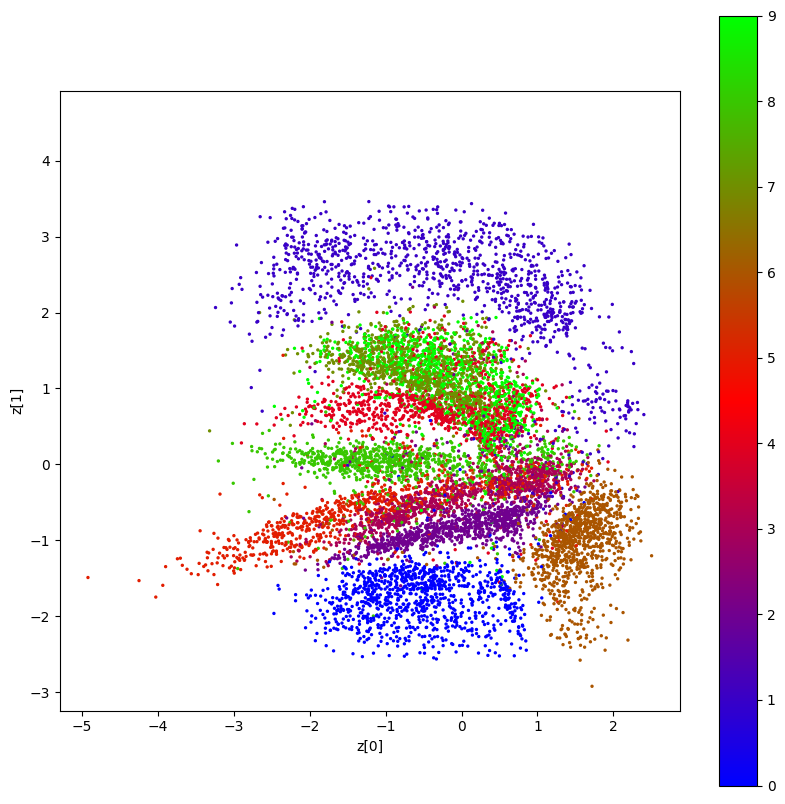

In [9]:
# plotting the images of the test dataset in the latent space.
import matplotlib.pyplot as plt

ds_all = torch.utils.data.DataLoader(ds, 10000, shuffle=False)
x, y = next(iter(ds_all))
x = x.to(device)
with torch.no_grad():
    _, _, z = en(x)

z = z.to("cpu").numpy()
y = y.numpy()

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

s = axs.scatter(z[:, 0], z[:, 1], c=y, cmap='brg', s=2)
axs.set_xlabel('z[0]')
axs.set_ylabel('z[1]')
plt.colorbar(s)
axs.axis('square')

plt.show()

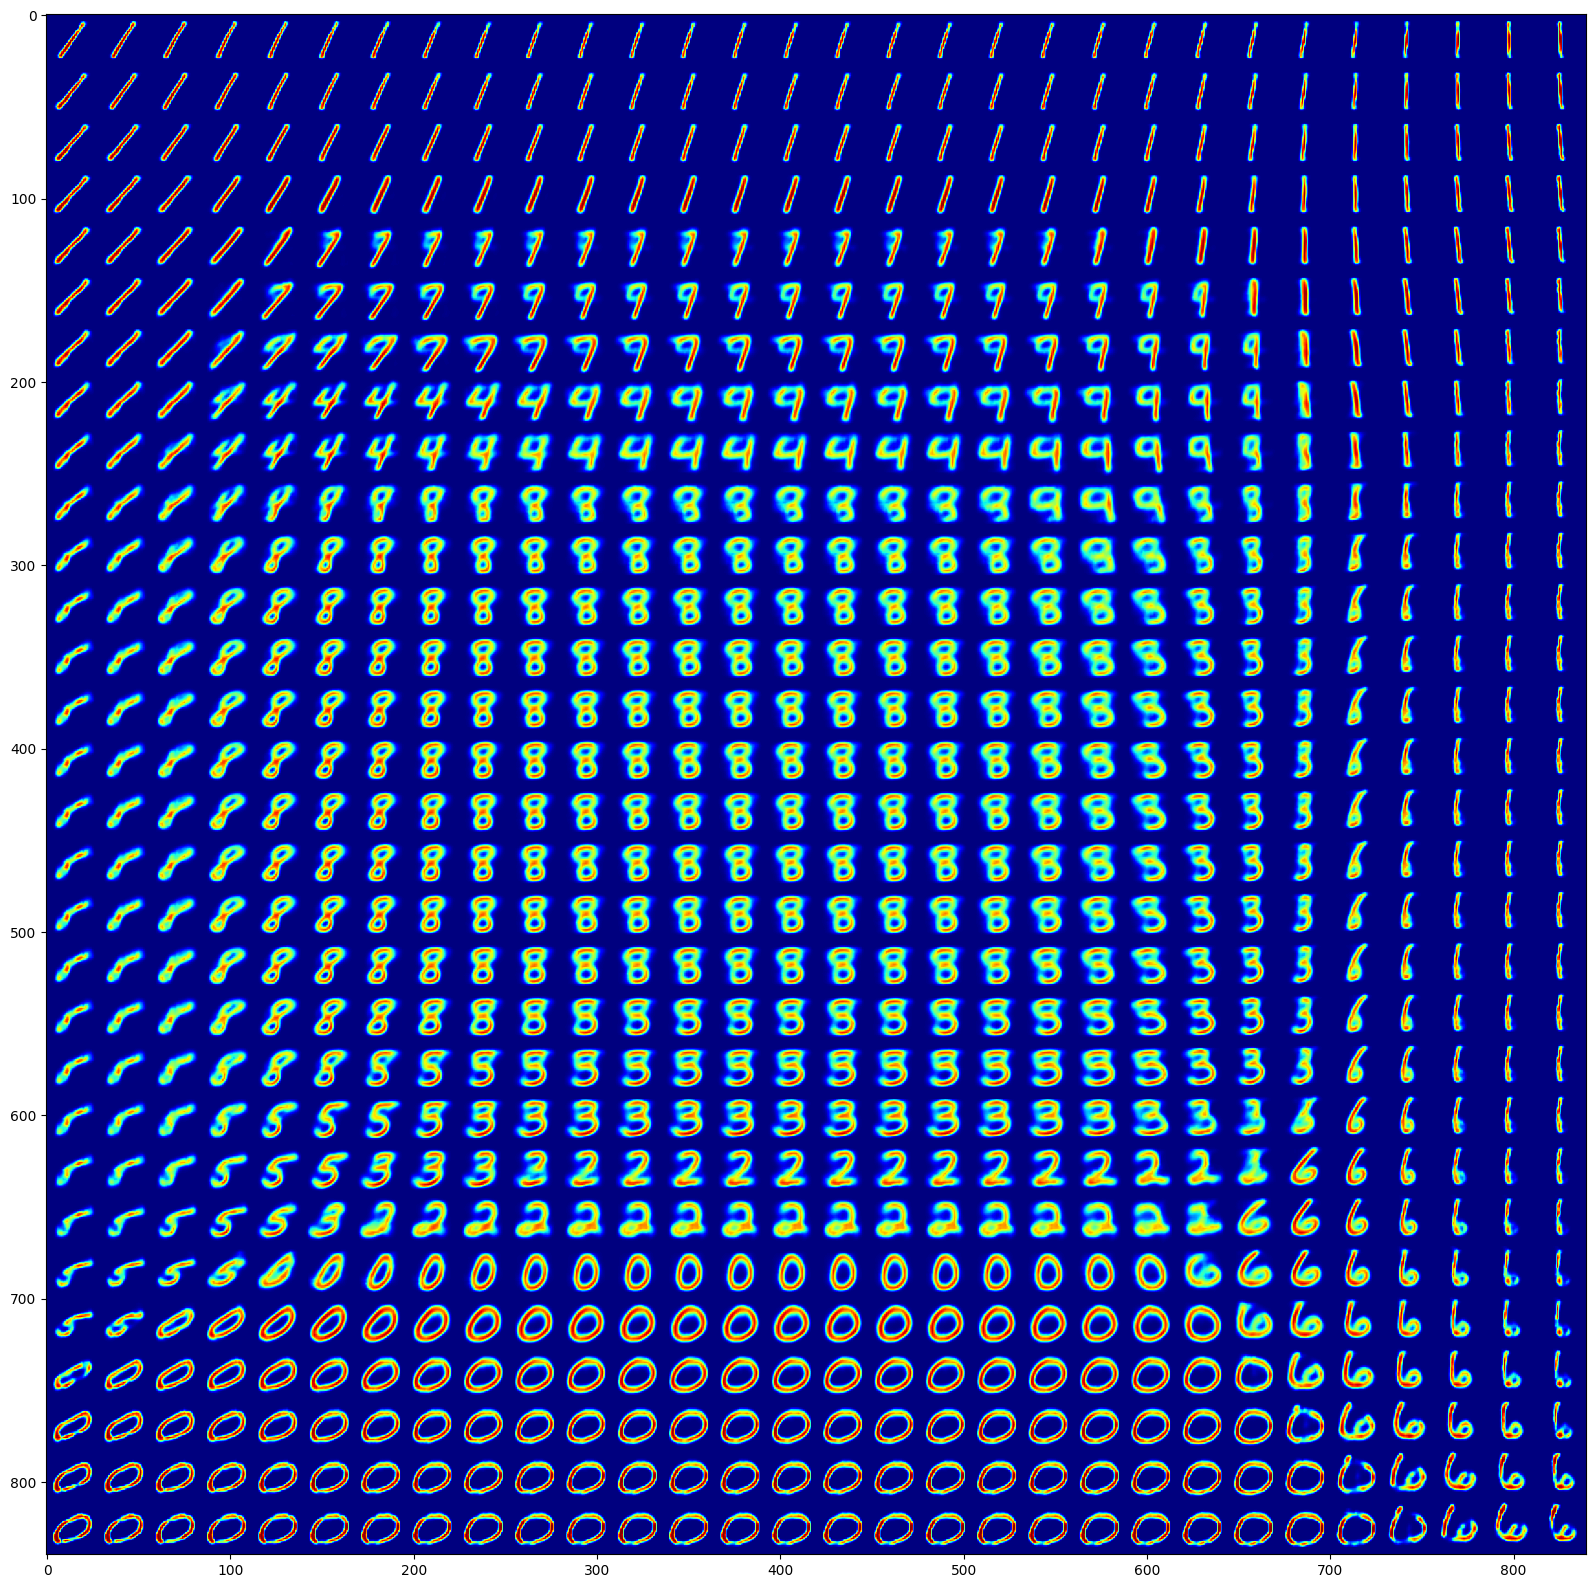

In [8]:
import numpy as np
n = 30  # generate 30x30 digits
all_digits_image = np.zeros((28 * n, 28 * n))

# Generate a grid using meshgrid
x_grid, y_grid = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
x_grid = x_grid * np.square(np.linspace(-np.sqrt(5), np.sqrt(5), n)).reshape((1,n))
y_grid = y_grid * np.square(np.linspace(-np.sqrt(5), np.sqrt(5), n)).reshape((n,1))

grid = np.concatenate((x_grid[...,np.newaxis], y_grid[...,np.newaxis]), axis=-1)
grid = grid.reshape((n*n,2))

with torch.no_grad():
    x_decoded = de(torch.tensor(grid, dtype=torch.float).to(device)).to("cpu").numpy()

# decoder for each square in the grid
c = 0
for i in range(n-1,-1,-1):
    for j in range(n):
        digit = x_decoded[c,...].squeeze()
        all_digits_image[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit
        c += 1

plt.figure(figsize=(20, 20))
plt.imshow(all_digits_image, cmap='jet')
plt.show()